The purpose of this notebook is to document data exploration processes with an n=50,000 sample of our Learn2Therm protein database. Doing so provides a workspace to select and optimize a model for predicting protein pair functionality between two sequences. Several classifier architectures were tested prior to the release of the final version of this component.

This notebook includes exploration of a Random Forest Classifier.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.ensemble
import sklearn.feature_selection
import unittest

In [2]:
cd /Users/loganroberts/Learn2Therm/PairProphet/notebooks

/Users/loganroberts/Learn2Therm/PairProphet/notebooks


In [3]:
#convert to pandas df
df = pd.read_csv('learn2therm_sample_50k_exploration.csv')

In [4]:
df.head()

,Unnamed: 0,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,thermo_index,...,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_seq,t_protein_seq,m_protein_desc,t_protein_desc,m_protein_len,t_protein_len
0,0,0.287582,0.217822,0.215686,160,0.792079,152,0.737864,131,875,...,1153.0,27.5,50.0,22.5,MAESGTSRRADHLVPVPGPDAEPPAVADELLRAVGRGDEQAFGRLY...,MPSQITESERIELAERFERDALPLLDQLYSAALRMTRNPADAEDLV...,ECF RNA polymerase sigma factor SigK,sigma-70 family RNA polymerase sigma factor,206,202
1,1,0.319635,0.295359,0.297872,218,0.919831,226,0.969957,282,11324,...,1014.0,25.0,54.0,29.0,MARIALVDDDRNILTSVSMTLEAEGFEVETYNDGQSALDAFNKRMP...,MRVLLVEDDPNTSRSIEMMLTHANLNVYATDMGEEGIDLAKLYDYD...,response regulator transcription factor,response regulator transcription factor,233,237
2,2,0.279621,0.234127,0.218924,211,0.837302,210,0.731707,96,875,...,1138.0,28.0,50.0,22.0,MKDTVVFVTGAARGIGAHTARLAVARGARVALVGLEPHLLADLAAE...,MTPEQIFSGQTAIVTGGASGIGAATVEHIARRGGRVFSVDLSYDSP...,SDR family oxidoreductase,SDR family oxidoreductase,287,252
3,3,0.327273,0.200743,0.214712,166,0.617100,163,0.696581,175,875,...,1077.0,28.0,50.0,22.0,MTSGLWERVLDGVWVTIQLLVLSALLATAVSFVVGIARTHRLWIVR...,MAMSRRKRGQLARGIQYAILVIVVVVLALLADWGKIGKAFFDWEAA...,ectoine/hydroxyectoine ABC transporter permeas...,amino acid ABC transporter permease,234,269
4,4,0.338710,0.318182,0.287671,60,0.909091,71,0.887500,61,9827,...,991.0,30.0,50.0,20.0,MIISLRRGLRFIRFIVFFAALVYLFYHVLDLFNGWISPVDQYQMPT...,MKRMVWRTLKVFIIFIACTLLFYFGLRFMHLEYEQFHRYEPPEGPA...,YqzK family protein,YqzK family protein,80,66


In [5]:
hmmer_structure = pd.read_csv('protein_match_50k')
hmmer_structure['protein_match'] = hmmer_structure['protein_match'].map({'Yes': 1, 'No': 0})
hmmer_structure['structure_match']  = [np.random.randint(0,2) for i in range(len(hmmer_structure))]
hmmer_structure

,Unnamed: 0,prot_pair_index,protein_match,Jaccard_Score,structure_match
0,0,48641291,1,1.00,0
1,1,92992745,1,1.00,1
2,2,157628663,1,1.00,1
3,3,136708305,1,1.00,1
4,4,133672542,1,1.00,1
...,...,...,...,...,...
48845,4875,78849058,0,0.25,1
48846,4876,108797464,1,1.00,1
48847,4877,161110219,0,0.25,1
48848,4878,74177185,1,0.50,0


In [6]:
# from sklearn.utils import resample

# # Assuming your data is in a pandas DataFrame called 'data'
# # Separate the majority and minority classes
# majority_class = hmmer_structure[hmmer_structure['protein_match'] == hmmer_structure['protein_match'].value_counts().idxmax()]
# minority_class = hmmer_structure[hmmer_structure['protein_match'] == hmmer_structure['protein_match'].value_counts().idxmin()]

# # Undersample the majority class to match the number of minority class samples
# n_samples = len(minority_class)
# undersampled_majority = resample(majority_class, n_samples=n_samples, replace=False)

# # Combine the undersampled majority class with the minority class
# balanced_data_hmmer = pd.concat([undersampled_majority, minority_class])

In [7]:
# majority_class = hmmer_structure[hmmer_structure['structure_match'] == hmmer_structure['structure_match'].value_counts().idxmax()]
# minority_class = hmmer_structure[hmmer_structure['structure_match'] == hmmer_structure['structure_match'].value_counts().idxmin()]

# # Undersample the majority class to match the number of minority class samples
# n_samples = len(minority_class)
# undersampled_majority = resample(majority_class, n_samples=n_samples, replace=False)

# # Combine the undersampled majority class with the minority class
# balanced_data_structure = pd.concat([undersampled_majority, minority_class])
# balanced_data_structure

In [8]:
def balance_data(dataframe, target_columns):
    #balances data based on target columns
    from sklearn.utils import resample
    
    # Ensure target_columns is a list, even if it's a single column.
    if not isinstance(target_columns, list):
        target_columns = [target_columns]

    for target in target_columns:
        # separate the majority and minority classes
        majority_class = dataframe[dataframe[target] == dataframe[target].value_counts().idxmax()]
        minority_class = dataframe[dataframe[target] == dataframe[target].value_counts().idxmin()]

        #create new dataframe with len(minority_class)
        n_samples = len(minority_class)
        undersampled_majority = resample(majority_class, n_samples=n_samples, replace=False)

        # Combine the undersampled majority class with the minority class
        dataframe = pd.concat([undersampled_majority, minority_class])
        print(f'DF length reduced to {dataframe.shape}')
        print(f'{target} value counts: {dataframe[target].value_counts()}')
    
    return dataframe

In [ ]:
df = pd.merge(df, hmmer_structure, on=['prot_pair_index'])
df.shape

In [10]:
balanced = balance_data(df, ['protein_match', 'structure_match'])

DF length reduced to (17108, 34)
protein_match value counts: 1    8554
0    8554
Name: protein_match, dtype: int64
DF length reduced to (17008, 34)
structure_match value counts: 0    8504
1    8504
Name: structure_match, dtype: int64


In [12]:
balanced.shape

(17008, 34)

In [8]:
df_seqs = df[['m_protein_seq', 't_protein_seq', 'prot_pair_index']]
df_seqs

,m_protein_seq,t_protein_seq,prot_pair_index
0,MARIALVDDDRNILTSVSMTLEAEGFEVETYNDGQSALDAFNKRMP...,MRVLLVEDDPNTSRSIEMMLTHANLNVYATDMGEEGIDLAKLYDYD...,92992745
1,MVTTGERQRNARGEGARLRLEIVAATQALLADGETATLRSIARRAG...,MNRPTYHHGDLRAAILTEAARLVAERGAERVSLRELAREAGVSHAA...,20752996
2,MGSTDRPDLAAMLAPLTRTLIAMERPVLETYGLTMWAYSVLVALSR...,MGHKDELIARIQRAEREFRRSVVSQAATDFFSVDLTMPQLRVVFFL...,24980629
3,MPRWVKIAVIVAVAAIVGVASVPLSQLGSGTITVTAQFADAAGLYN...,MKVPFRERNPVPIALASFTALAVLMLGAYFIEDLPVIGGGTTYSAR...,86923756
4,MQIKDSVAVVTGGASGLGLATTKRLLDAGGSVVVIDLKGEDVVAEL...,MTGTVVITGGSRGIGAATAVLAAERGWQVAVSFRERRDAAEQVVRR...,85102366
...,...,...,...
17103,MSTTEQRVAIVTGAARGIGAATAVRLAAEGRAVAVLDLDEAACKDT...,MESSSFPLRGKTALVTGVSRRRGIGYAVATRLAELGADIVIHHFVP...,136836774
17104,MRRQVGSVPGVTRTAGAAGGGAAARTAPGGPPDVVLMSCSHPRAAE...,MAESHSTTRSGQIRVFVLDDHEVVRRGVRDLLDAEPDITVVGEAET...,14456723
17105,MDNATFRLGDDLSVRLPGHSRWIGQVEREQRWLPWLAPRLPLTVST...,MPPQPRPLRPNDPREIGGFALLGRLGEGGQGTVYLGGAPDGRRVAV...,78849058
17106,MIRLAELTKTYPGQQHPAVDGISMEVAEGEIVVLVGPSGCGKTTTL...,MTEQPILSARGLTVDFRLRGGRRARAVDGVDLDLAPGEVLALAGES...,161110219


In [9]:
#get rid of stuff that isn't quantitative

df = df.drop(columns = ['Unnamed: 0_x', 'Unnamed: 0_y','thermo_index', 'm_protein_seq', 't_protein_seq',
                        'm_protein_desc', 't_protein_desc'])

In [10]:
df.columns

Index(['local_gap_compressed_percent_id', 'scaled_local_query_percent_id',
       'scaled_local_symmetric_percent_id', 'query_align_len',
       'query_align_cov', 'subject_align_len', 'subject_align_cov',
       'bit_score', 'meso_index', 'prot_pair_index', 'meso_protein_int_index',
       'thermo_protein_int_index', 'taxa_pair_index',
       'local_gap_compressed_percent_id_16s',
       'scaled_local_query_percent_id_16s',
       'scaled_local_symmetric_percent_id_16s', 'query_align_cov_16s',
       'subject_align_cov_16s', 'bit_score_16s', 'm_ogt', 't_ogt',
       'ogt_difference', 'm_protein_len', 't_protein_len', 'protein_match',
       'Jaccard_Score', 'structure_match'],
      dtype='object')

From pairplot below, it looks like query_align_cov_16s and subject_align_cov_16s dont correlate with target. Let's remove them.

In [11]:
# sns.pairplot(df.sample(500),height = 4)

In [12]:
df = df.drop(columns = ['query_align_cov_16s', 'subject_align_cov_16s'])

In [13]:
df.describe()

,local_gap_compressed_percent_id,scaled_local_query_percent_id,scaled_local_symmetric_percent_id,query_align_len,query_align_cov,subject_align_len,subject_align_cov,bit_score,meso_index,prot_pair_index,...,scaled_local_symmetric_percent_id_16s,bit_score_16s,m_ogt,t_ogt,ogt_difference,m_protein_len,t_protein_len,protein_match,Jaccard_Score,structure_match
count,17108.000000,17108.000000,17108.000000,17108.000000,17108.000000,17108.000000,17108.000000,17108.000000,17108.000000,1.710800e+04,...,17108.000000,17108.000000,17108.000000,17108.000000,17108.000000,17108.000000,17108.000000,17108.000000,17108.000000,17108.000000
mean,0.335235,0.253648,0.245991,199.571312,0.760849,198.742226,0.731154,205.394611,8120.993161,9.121505e+07,...,0.904765,1060.248714,27.375789,51.539689,24.163900,277.333762,264.007131,0.500000,0.452316,0.500000
std,0.081333,0.098624,0.100621,59.690919,0.145705,60.047306,0.190792,161.052698,4602.110894,5.224819e+07,...,0.015171,75.203055,3.758359,3.802579,3.614472,63.182764,68.397526,0.500015,0.338385,0.500015
min,0.164103,0.081301,0.045977,21.000000,0.284553,21.000000,0.083916,35.000000,5.000000,8.858000e+03,...,0.880026,891.000000,7.000000,41.000000,20.000000,30.000000,29.000000,0.000000,0.000000,0.000000
25%,0.290323,0.193370,0.189189,167.000000,0.638298,166.000000,0.613496,109.000000,4162.000000,4.676635e+07,...,0.893338,1008.000000,27.500000,50.000000,22.000000,239.000000,227.000000,0.000000,0.200000,0.000000
50%,0.318681,0.233577,0.229060,207.000000,0.761905,207.000000,0.756434,178.000000,8046.000000,9.146144e+07,...,0.903480,1055.000000,28.000000,52.500000,24.500000,271.000000,260.000000,0.500000,0.320513,0.500000
75%,0.353672,0.282700,0.273755,231.000000,0.890285,229.000000,0.890625,244.000000,12103.000000,1.360614e+08,...,0.914586,1107.000000,30.000000,52.500000,24.500000,326.000000,315.000000,1.000000,0.750000,1.000000
max,0.923077,0.918919,0.918919,399.000000,1.000000,399.000000,1.000000,1608.000000,16564.000000,1.814866e+08,...,0.996439,1679.000000,40.000000,78.000000,56.000000,400.000000,400.000000,1.000000,1.000000,1.000000


Split data into dev and test, and then split that into train and validation.

In [14]:
#drop columns that don't exihibit signficant pearson correlation with bit_score

df = df.drop(columns = ['meso_index', 'meso_protein_int_index', 'local_gap_compressed_percent_id_16s', 
                        'scaled_local_query_percent_id_16s', 'scaled_local_symmetric_percent_id_16s',
                       'bit_score_16s', 'm_ogt', 't_ogt', 'taxa_pair_index', 'thermo_protein_int_index'
                       , 'prot_pair_index', 'ogt_difference'])

In [15]:
df = df.drop(columns = ['Jaccard_Score'])


In [16]:
df.columns

Index(['local_gap_compressed_percent_id', 'scaled_local_query_percent_id',
       'scaled_local_symmetric_percent_id', 'query_align_len',
       'query_align_cov', 'subject_align_len', 'subject_align_cov',
       'bit_score', 'm_protein_len', 't_protein_len', 'protein_match',
       'structure_match'],
      dtype='object')

In [17]:
#choosing 80/20 split instead of 85/15 because of volume of data

dev, test = sklearn.model_selection.train_test_split(df, test_size=0.15, random_state=1)

train, val = sklearn.model_selection.train_test_split(dev, test_size=0.15, random_state=1)

print(dev.shape)
print(test.shape)
print(train.shape)
print(val.shape)

(14541, 12)
(2567, 12)
(12359, 12)
(2182, 12)


In [18]:
#ID target and features, separate into separate arrays

target = [columns for columns in df[['protein_match', 'structure_match']]]
input_features = [columns for columns in df.drop(columns=['protein_match', 'structure_match'])]

In [19]:
input_features

['local_gap_compressed_percent_id',
 'scaled_local_query_percent_id',
 'scaled_local_symmetric_percent_id',
 'query_align_len',
 'query_align_cov',
 'subject_align_len',
 'subject_align_cov',
 'bit_score',
 'm_protein_len',
 't_protein_len']

In [20]:
print(input_features)
print(target)

['local_gap_compressed_percent_id', 'scaled_local_query_percent_id', 'scaled_local_symmetric_percent_id', 'query_align_len', 'query_align_cov', 'subject_align_len', 'subject_align_cov', 'bit_score', 'm_protein_len', 't_protein_len']
['protein_match', 'structure_match']


In [60]:
#split X and y

dev_X = dev[input_features].values
test_X = test[input_features].values

dev_y = dev[target].values
test_y = test[target].values

print(dev_X.shape, test_X.shape, dev_y.shape, test_y.shape)

(14541, 10) (2567, 10) (14541, 2) (2567, 2)


In [61]:
#same thing for training and validation data

train_X = train[input_features].values
val_X = val[input_features].values

train_y = train[target].values
val_y = val[target].values

Scale the data

In [62]:
scaler = sklearn.preprocessing.StandardScaler()
dev_X = scaler.fit_transform(dev_X)
test_X = scaler.fit_transform(test_X)
train_X = scaler.fit_transform(train_X)
val_X = scaler.fit_transform(val_X)

Train the model

In [64]:
#Random Forest

model = sklearn.ensemble.RandomForestClassifier(oob_score=True)
model.fit(dev_X, dev_y)

RandomForestClassifier(oob_score=True)

In [79]:
# Obtain predicted class probabilities
y_pred_prob = model.predict_proba(dev_X)

# Compute uncertainty estimates using out-of-bag samples
oob_predictions = model.oob_decision_function_

uncertainty = np.mean(np.var(oob_predictions, axis=1), axis=0)

# 'y_pred_prob' contains predicted class probabilities, and 'uncertainty' represents the uncertainty estimates


In [80]:
uncertainty

array([0.09664674, 0.09664674])

In [25]:
import joblib

In [26]:
joblib.dump(model, 'trained_model.pkl')

['trained_model.pkl']

In [27]:
joblib.load('trained_model.pkl')

RandomForestClassifier()

Test the model, report relevant statistics

In [28]:
score = model.score(test_X, test_y)
print('Model score is: {}'.format(score))

preds = model.predict(test_X)
len(preds)

Model score is: 0.7312037397740553


2567

In [29]:
preds

array([[0, 0],
       [1, 1],
       [0, 0],
       ...,
       [0, 0],
       [1, 1],
       [1, 1]])

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

true_labels = test_y

predicted_labels = preds

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels, average=None)

# Calculate recall
recall = recall_score(true_labels, predicted_labels, average=None)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average=None)

# Print the scores
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.7312037397740553
Precision: [0.73941909 0.73941909]
Recall: [0.70323599 0.70323599]
F1 Score: [0.72087379 0.72087379]


In [31]:
def train_model(dataframe, columns=[], target=[]):
    '''
    Takes dataframe and splits it into a training and testing set.
    Trains a RF Classifier with data.

    Args:
        dataframe: Pandas dataframe
        columns: list of strings, representing input features
        target: list of strings, representing target feature(s)

    Returns:
        Sk-learn model object
        train data (features)
        train data (target)
        validation data (features)
        validation data (target)
    '''
    # split data
    train, val = sklearn.model_selection.train_test_split(
        dataframe, test_size=0.15, random_state=1)

    # test input arguments
    assert "pandas.core.frame.DataFrame" in str(type(train))
    assert "pandas.core.frame.DataFrame" in str(type(val))
    assert "str" in str(type(columns[0]))
    assert "str" in str(type(target[0]))

    # split into input and output feature(s)
    train_X = train[columns].values
    val_X = val[columns].values

    train_y = train[target].values.reshape(-1, 1)
    val_y = val[target].values.reshape(-1, 1)

    # scale data
    scaler = sklearn.preprocessing.StandardScaler()
    train_X = scaler.fit_transform(train_X)
    val_X = scaler.fit_transform(val_X)

    # train model with hyperparams optimized
    model = sklearn.ensemble.RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        max_samples=0.3,
        max_features=0.5,
        min_weight_fraction_leaf=0,
        min_samples_split=17)

    model = model.fit(train_X, train_y.ravel())

    return model, train_X, train_y, val_X, val_y

def train_model_structure(dataframe, columns=[], target=[]):
    '''
    Takes dataframe and splits it into a training and testing set.
    Trains a RF Classifier with data.

    Args:
        dataframe: Pandas dataframe
        columns: list of strings, representing input features
        target: list of strings, representing target feature(s)

    Returns:
        Sk-learn model object
        train data (features)
        train data (target)
        validation data (features)
        validation data (target)
    '''
    # split data
    train, val = sklearn.model_selection.train_test_split(
        dataframe, test_size=0.15, random_state=1)

    # test input arguments
    assert "pandas.core.frame.DataFrame" in str(type(train))
    assert "pandas.core.frame.DataFrame" in str(type(val))
    assert "str" in str(type(columns[0]))
    assert "str" in str(type(target[0]))

    # split into input and output feature(s)
    train_X = train[columns].values
    val_X = val[columns].values

    train_y = train[target].values
    val_y = val[target].values

    # scale data
    scaler = sklearn.preprocessing.StandardScaler()
    train_X = scaler.fit_transform(train_X)
    val_X = scaler.fit_transform(val_X)

    # train model with hyperparams optimized
    model = sklearn.ensemble.RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        max_samples=0.3,
        max_features=0.5,
        min_weight_fraction_leaf=0,
        min_samples_split=17)

    model = model.fit(train_X, train_y)

    return model, train_X, train_y, val_X, val_y


def validate_model(model, val_X, val_y):
    '''
    Takes a trained model and test data and tests the model.

    Args:
        model: sklearn.neighbors.KNeighborsClassifier
        test_X: numpy array
        test_y: numpy array

    Returns:
        Vector of predictions based on the model (numpy array)
         Precision score of model
    '''
    # test input arguments
    assert "sklearn" in str(type(model))
    assert "numpy.ndarray" in str(type(val_X))
    assert "numpy.ndarray" in str(type(val_y))

    preds = model.predict(val_X)

    # not printed during model validation step
    precision_score = sklearn.metrics.precision_score(val_y, preds, average=None)

    return preds, precision_score


def plot_model(model, val_X, val_y):
    '''
    Takes a test classifier model and plots the confusion matrix.

    Args:
        model: sklearn.neighbors.RandomForestClassifier
        test_X: numpy array
        test_y: numpy array

    Returns:
        Confusion predictions vs. observations
        Model score
    '''
    # test input arguments
    assert "sklearn" in str(type(model))
    assert "numpy.ndarray" in str(type(val_X))
    assert "numpy.ndarray" in str(type(val_y))

    score = model.score(val_X, val_y)
    preds = model.predict(val_X)

    # plot confusion matrix
    confusion_matrix = sklearn.metrics.confusion_matrix(preds, val_y)
    cm_plot = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix)

    cm_plot.plot(cmap=plt.cm.Blues)
    cm_plot.ax_.set_title('Confusion Matrix')

    return score


def rf_wrapper(dataframe, target):
    '''
    Takes a test classifier model and plots the confusion matrix.

    Args:
        dataframe: Pandas dataframe

    Returns:
        Target feature predictions
        Parity plot
    '''
    assert 'pandas.core.frame.DataFrame' in str(type(dataframe))

    print(target)
    print(dataframe.columns)

    # define input features
    input_features = [columns for columns in dataframe.drop(columns=target)]

    print(input_features)


    # train the model based off data split
    if 'structure_match' not in target:
        # if target is one class
        print('hmmer')
        model, _, _, val_X, val_y = train_model(
            dataframe, columns=input_features,
            target=target
        )
    else:
        # if target is two class
        print('hmmer + structures')
        model, _, _, val_X, val_y = train_model_structure(
            dataframe, columns=input_features,
            target=target
        )

    # test the model and return predictions
    preds, _ = validate_model(model, val_X, val_y)

    # plot the results of the model
    # score = plot_model(model, val_X, val_y)

    return preds, score, model


In [32]:
def train_val_wrapper(dataframe, target, feature_list=None):
    '''
    Takes dataframe and runs it through cleaning script.
    Generates features with iFeatureOmegaCLI.
    Passes result through RF Classifier model.

    Args:
        Dataframe (pandas dataframe)
        Features from iFeatureOmega (list)

    Returns:
        Vector of predictions (numpy arrray)
        Parity plot
        Model score
    '''
    # clean input dataframe
    dataframe = input_cleaning_wrapper(dataframe)

    if feature_list is not None:
        # generate features from amino acid sequence
        dataframe = create_new_dataframe(dataframe, ['sequences_a.fasta', 
                                    'sequeneces_b.fasta'], 
                                    descriptors=[feature for feature in feature_list])
    else:
        pass

    #drop sequences
    dataframe.drop(columns=['m_protein_seq', 't_protein_seq'])
    # run through model
    score = rf_wrapper(dataframe, target)[1]
    model = rf_wrapper(dataframe, target)[2]

    return score, model 




In [33]:
rf_wrapper(df, target=['protein_match', 'structure_match'])

['protein_match', 'structure_match']
Index(['local_gap_compressed_percent_id', 'scaled_local_query_percent_id',
       'scaled_local_symmetric_percent_id', 'query_align_len',
       'query_align_cov', 'subject_align_len', 'subject_align_cov',
       'bit_score', 'm_protein_len', 't_protein_len', 'protein_match',
       'structure_match'],
      dtype='object')
['local_gap_compressed_percent_id', 'scaled_local_query_percent_id', 'scaled_local_symmetric_percent_id', 'query_align_len', 'query_align_cov', 'subject_align_len', 'subject_align_cov', 'bit_score', 'm_protein_len', 't_protein_len']
hmmer + structures


(array([[0, 0],
        [1, 1],
        [0, 0],
        ...,
        [0, 0],
        [0, 0],
        [0, 0]]),
 0.7312037397740553,
 RandomForestClassifier(max_features=0.5, max_samples=0.3, min_samples_split=17,
                        min_weight_fraction_leaf=0, n_estimators=200))

In [34]:
def train_model(dataframe, columns = [],  target = []):
    """
    Takes dataframe and splits it into a training and testing set. 
    Note: Data is called train and test, but this test set is currently
    closer to a validation set. Keeping nomenclature to keep model robust.
    Trains a KNN classifier model with selected data.
    
    Params
    ----------
    dataframe: Pandas dataframe 
    columns: list of strings, representing input features
    target: list of strings, representing target feature(s)

    Returns
    -------
    -Sk-learn model object
    -train data (features)
    -train data (target)
    -validation data (features)
    -validation data (target)
    """
    #split data
    dev, test = sklearn.model_selection.train_test_split(dataframe, test_size=0.15, random_state=1)
    
    #test input arguments
    assert "pandas.core.frame.DataFrame" in str(type(dev))
    assert "pandas.core.frame.DataFrame" in str(type(test))
    assert "str" in str(type(columns[0]))
    assert "str" in str(type(target[0]))
   
    #split into input and output feature(s)
    dev_X = dev[columns].values
    test_X = test[columns].values

    dev_y = dev[target].values.reshape(-1,1)
    test_y = test[target].values.reshape(-1,1)
    
    #scale data
    scaler = sklearn.preprocessing.StandardScaler()
    dev_X = scaler.fit_transform(dev_X)
    test_X = scaler.fit_transform(test_X)
    
    #train model
    model = sklearn.ensemble.RandomForestClassifier()
    model = model.fit(dev_X, dev_y.ravel())
    
    return model, dev_X, dev_y, test_X, test_y
    

In [35]:
model, dev_X, dev_y, test_X, test_y = train_model(df, columns = input_features, 
                                          target='protein_match')

In [36]:
class TestModelTraining(unittest.TestCase):
    
    def test_invalid_inputs(self):
    
        #test that input data type is correct
        
        try:
            train_model([1,2,3], columns = 'string', target = 'string')
            self.assertTrue(False)
        except AssertionError:
            self.assertTrue(True)
    
#     def test_input_distro(self):
        
#         #test that dev and test features have similar Jensen Shannon Distribution
        
#         JSD = (
#             scipy.stats.bootstrap((train_reg(split_data(df)[0], split_data(df)[1],
#                                 columns = input_features, target=target)[1], train_reg(split_data(df)[0], 
#                                 split_data(df)[1], columns = input_features, target=target)[3]), 
#                                   JSD_dev_and_test, n_resamples=1000, 
#                                   batch=5, method='percentile')
#         )

#         div = JSD.confidence_interval[1]
        
#         #asserts that the divergence between data sets is sufficiently low
#         assert abs(div) < 0.3, "Warning! High JSD between dev and test set!"
        
    def test_output_format(self):
        
        #asserts that function returns 4 objects to be assigned to pearson_corr, model, test_X, test_y
        assert len(train_model(df, columns = input_features, 
                                          target = target)) == 5
        

suite = unittest.TestLoader().loadTestsFromTestCase(TestModelTraining)
_ = unittest.TextTestRunner().run(suite)

.E
ERROR: test_output_format (__main__.TestModelTraining)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-36-c2adb03a26fe>", line 33, in test_output_format
    assert len(train_model(df, columns = input_features,
  File "<ipython-input-34-13865bb0cfb5>", line 45, in train_model
    model = model.fit(dev_X, dev_y.ravel())
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 345, in fit
    X, y = self._validate_data(
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py", line 565, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/validation.py", line 1124, in check_X_y
    check_consistent_length(X, y)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packa

In [37]:
#need to fix this

def evaluate_model(model, test_X, test_y):
    
    """
    Takes a trained model and test data and tests the model.
    
    Params
    ----------
    model: sklearn.neighbors.KNeighborsClassifier
    test_X: numpy array
    test_y: numpy array

    Returns
    -------
    Vector of predictions based on the model (numpy array)
    """
    
    #test input arguments
    assert "sklearn" in str(type(model))
    assert "numpy.ndarray" in str(type(test_X))
    assert "numpy.ndarray" in str(type(test_y))
    
    preds = model.predict(test_X)
    
    return preds

In [38]:
preds = evaluate_model(model, test_X, test_y)
preds

array([0, 1, 0, ..., 0, 1, 1])

In [39]:
class TestModelPerformance(unittest.TestCase):

    def test_asserts(self):
        model, _, _, test_X, test_y = train_model(
            df, columns=input_features, target='protein_match'
        )
        # assert that input types are correct
        with self.assertRaises(AssertionError):
            evaluate_model(model, [1, 2, 3], test_y)
            
    def test_model_output(self):
        model, _, _, test_X, test_y = train_model(
            df, columns=input_features, target='protein_match'
        )
        # assert output type is correct
        output = evaluate_model(model, test_X, test_y)
        self.assertIsInstance(output, np.ndarray)
        
    def test_pred_dimension(self):
        model, _, _, test_X, test_y = train_model(df, 
            columns=input_features, target='protein_match'
        )
        # want to check that the number of predictions is equal to the number of test examples
        preds = evaluate_model(model, test_X, test_y)
        self.assertEqual(len(test_y), len(preds))

suite = unittest.TestLoader().loadTestsFromTestCase(TestModelPerformance)
_ = unittest.TextTestRunner().run(suite)


...
----------------------------------------------------------------------
Ran 3 tests in 9.247s

OK


A good test here can be adding outliers and seeing how much the score and predictions change (probably for the above function).

In [40]:
def plot_model(model, test_X, test_y):
    """
    Takes a test KNN Classifier model and plots the confusion matrix.
    
    Params
    ----------
    model: sklearn.neighbors.KNeighborsClassifier
    test_X: numpy array
    test_y: numpy array

    Returns
    -------
    -Confusion predictions vs. observations
    -Model score
    """
    
    #test input arguments
    assert "sklearn" in str(type(model))
    assert "numpy.ndarray" in str(type(test_X))
    assert "numpy.ndarray" in str(type(test_y))
    
    score = model.score(test_X, test_y)
    preds = evaluate_model(model, test_X, test_y)
   
    # plot confusion matrix
    confusion_matrix = sklearn.metrics.confusion_matrix(preds, test_y)
    cm_plot = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix)
    
    cm_plot.plot(cmap=plt.cm.Blues)
    cm_plot.ax_.set_title('Confusion Matrix')
    
    return score
    

0.7284768211920529

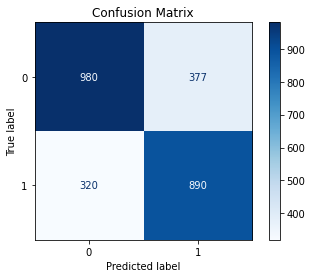

In [41]:
#make some appropriate display labels here

plot_model(model, test_X, test_y)

In [42]:
#wrapper function

def RF_wrapper(dataframe):
    """
    Takes dataframe and runs it through kNN model.
    
    Params
    ----------
    dataframe: Pandas dataframe 

    Returns
    -------
    -Target feature predictions
    -Parity plot
    """
    
    assert 'pandas.core.frame.DataFrame' in str(type(dataframe))

    #user inputs target feature
    target = 'protein_match'
    
    #define input features
    input_features = [columns for columns in dataframe]
    
    input_features.remove(target)

    #train the model based off data split
    model, dev_X, dev_y, test_X, test_y = train_model(
                                        dataframe, columns=input_features, 
                                        target=target
                                                   )
    
    #test the model and return predictions
    preds = evaluate_model(model, test_X, test_y)

    #plot the results of the model
    plot_model(model, test_X, test_y)
    
    return preds

array([1, 1, 1, ..., 0, 0, 0])

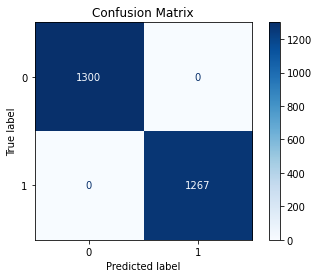

In [43]:
RF_wrapper(df)

In [44]:
class TestWrapper(unittest.TestCase):
    
    def test_wrapper_input(self):
        #test that input data type is correct
        try:
            RF_wrapper([1,2,3])
            self.assertTrue(False)
        except AssertionError:
            self.assertTrue(True)

    def test_wrapper_output(self):
        model, _, _, test_X, test_y = train_model(
            df, 
            columns=input_features, target='protein_match'
        )
        # assert output type is correct
        output = evaluate_model(model, test_X, test_y)
        self.assertIsInstance(output, np.ndarray)
        
    def test_output_dimension(self):
        model, _, _, test_X, test_y = train_model(
            df, 
            columns=input_features, target='protein_match'
        )
        # want to check that the number of predictions is equal to the number of test examples
        preds = evaluate_model(model, test_X, test_y)
        self.assertEqual(len(test_y), len(preds))
        

suite = unittest.TestLoader().loadTestsFromTestCase(TestWrapper)
_ = unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 6.089s

OK


**IGNORE BELOW**

In [45]:
# #plot empirical distribution of scaled_local_query_percent_id

# target = df['protein_match']
# #create histplot
# fig, ax = plt.subplots()

# sns.histplot(data = df, x = target)

# ax.set_title('Sample Histogram', fontsize=16)
# ax.set_xlabel('Class', fontsize=14)
# ax.set_ylabel('Count', fontsize=14)

Things I've tried to improve model: 

1. drop bit scores over 1000
2. Switch to 85/15 train/test split
3. Lasso regression - not great
4. Ridge regression - R2 = 0.87, about the same as normal Linear regression
5. KNN regression (n_neighbors optimized at 8) gives best result, R2 = ~0.93 --> 
*got it up to .942 by removing a few features
6. Decision tree regressor was slightly worse than KNN
7. Input DT classifier and RF classifier. RF classifier has best performance
8. Changed target to binary protein function match